# RAMP on generating anime images

_MAI Huu Tan, CARON Marceau, SALOMON Yohann, LIU Annie, BERTHOLOM François & BIGOT Alexandre_

## Table of Contents

1. [Introduction](##Introduction)

1. [Getting started with the RAMP starting kit](##GettingstartedwiththeRAMPstartingkit)

    1. [Software prerequisites](###Softwareprerequisites)
    1. [Getting the data](###Gettingthedata)

    

1. [The data](##Thedata)
    1. [Datasets and loaders with ```torch```](###Datasetsandloaderswith```torch```)

1. [Building a generative model using ```torch```](##Buildingagenerativemodelusing```torch```)
    1. [Variational Auto-Encoder (VAE)](###VariationalAuto-Encoder(VAE))
    1. [Generative Adversarial Networks (GANs)](###GenerativeAdversarialNetworks(GANs))
1. [Workflow](##Workflow)
    1. [The model to submit](###Themodeltosubmit)
    1. [Evaluation](###Evaluation)
    1. [Validation](###Validation)
    1. [Submitting to the online challenge](###Submittingtotheonlinechallenge)

## Introduction

The task of this challenge is to build a generative model that can create realistic images of anime faces, given a set of training data. Generative models are a class of machine learning models that aim to learn the underlying probability distribution of the data, allowing them to generate new samples that are similar to the training data.

The ability to generate new, high-quality data has numerous applications in various fields, including art, entertainment, and gaming. In particular, the task of generating anime faces has become increasingly popular in the anime and manga communities, where the demand for high-quality illustrations is ever-increasing.

Generative modeling has gained considerable attention in recent years due to rapid and spectacular advances, with a lot of new practical techniques. The state of the art in image generation is currently achieved with diffusion or score-based models, which are quite expensive in terms of computational resources, requiring both long training and inference times. In this challenge, the aim is to build, train and fine-tune generative models that can generate high-quality and diverse samples with an input of small dimension compared to that of the generated images.

Various approaches have been developed to tackle this problem, including generative adversarial networks (GANs), variational auto-encoders (VAEs), and flow-based models.

![ganyu](https://cdn.discordapp.com/attachments/1062719202806480966/1079371652191748096/103118764_p3_master1200_.jpg)

In particular, diffusion and score-based models became very popular for generating anime artwork. For example, NovelAI is based on Stable Diffusion and quickly became popular for being able to generate high quality anime illustrations from text inputs. The image above was generated by Novel AI, it is an image of Ganyu, a character from the well-known game Genshin Impact.

This challenge provides an opportunity to explore various deep learning techniques and push the limits of generative modeling for anime face generation, in a more simplistic setting. The competitor is asked to generate a colored $64 \times 64$ image that shows the face of an anime character.

The provided dataset is an adapted version of [Brian Chao's Anime Face Dataset](https://github.com/bchao1/Anime-Face-Dataset). The public data consists of roughly 30 000 images in jpg format, split into three training sets of roughly 10 000 images each. The images have been centered and cropped, thus all have a size of $64 \times 64$. The private dataset contains roughly 30 000 images.

Since those datasets have no image in common, the challenge will test the robustness of the competitor's model, as well as its ability to adapt to each of the training sets.

In [2]:
# % matplotlib inline
import os
import numpy as np
from pathlib import Path

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize, RandomHorizontalFlip
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
from torchmetrics.image.inception import InceptionScore
from pathlib import Path
import torchvision.utils as vutils
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

seed = 0
torch.manual_seed(seed)
print(f'Torch random seed: {seed}.')

Torch random seed: 0.


## Getting started with the RAMP starting kit
<a href="GTr"></a>
### Software prerequisites
This starting kit requires ```torch``` to run, however, to build and deploy your generative model, you may use any deep learning library you are comfortable with (```tensorflow```, ```jax```, etc.).

To install the dependancies (including ```torch```) using ```pip``` you may run:

In [3]:
# !pip install -r requirements.txt


### Getting the data
The public train and test data can be downloaded by running from the root of the starting kit:

In [4]:
# !python download_data.py

## The data

### Datasets and loaders with ```torch```

To exemplify the creation and usage of datasets and dataloaders using ```torch```, we are going to load data from all the public training set.

In [5]:
# Getting the paths of the training data
__file__ = "./anime_faces_starting_kit.ipynb"
PATH = Path(__file__).parent / "data"

paths = []
for p in PATH.rglob("*.jpg"):
    paths.append(p)

In [6]:
print(paths[:5])

[WindowsPath('data/train_1/10001.jpg'), WindowsPath('data/train_1/10007.jpg'), WindowsPath('data/train_1/10011.jpg'), WindowsPath('data/train_1/10015.jpg'), WindowsPath('data/train_1/10018.jpg')]


Image id: 10011.jpg
Image size: (64, 64)


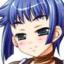

In [7]:
example = Image.open(paths[2])
print(f'Image id: {paths[2].name}')
print(f'Image size: {example.size}')
example

When loading images to ```Python``` using the ```pillow``` library, they come in a format that is not suitable to work on a deep learning task. 

In [8]:
type(example)

PIL.JpegImagePlugin.JpegImageFile

```torch.transforms``` has a variety of methods to work with images and make a transition between ```pillow``` and ```torch```. 

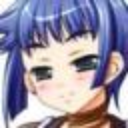

In [9]:
Resize(128)(example)

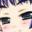

In [10]:
CenterCrop(32)(example)

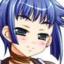

In [11]:
RandomHorizontalFlip(1)(example)

In [12]:
example_ten = ToTensor()(example)
example_ten.size()

torch.Size([3, 64, 64])

It is often more convenient to have a series of transforms that we apply to every image we are going to use for the training phase. In this challenge, the images are already formatted, so there is no need to resize or crop them.

In [13]:
image_size = 64
channels = 3

training_transform = Compose([
    # Resize(image_size),
    # CenterCrop(image_size),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

example_ten = training_transform(example)
example_ten.size()

torch.Size([3, 64, 64])

To apply this transform to every image we want to load in order to train the model, we define a subclass of the ```torch.utils.data.Dataset``` class.

In [14]:
class ImageSet(Dataset):
    """This class inherits from the Dataset class of PyTorch and is used to load the images locally with the paths of the images.

    The images are already transformed beforehand, so all there is to do in order to feed them to the metrics is to send them in
    mini-batches using a DataLoader object.
    """

    def __init__(self, paths, transform, preload=False):
        """Initializes the dataset from a tuple of paths.

        Args:
            paths (tuple of `str` objects): tuple of strings containing the paths of the images used in the Dataset.
            transform (Compose): A composition of transforms to be applied on the images.
            preload (bool, optional): A boolean to indicate whether the images are preloaded as PyTorch Tensor objects. Defaults to False.
        """
        self.paths = paths
        self.transform = transform
        self.preload = preload
        if self.preload:
            self.files = [
                self.transform(
                    Image.open(path)
                ) for path in self.paths]

    def __getitem__(self, index):
        """Gets an item from the dataset.

        Args:
            index (int): The index of the image in the dataset.

        Returns:
            Tensor: the `index`-th image in the dataset.
        """
        if self.preload:
            return self.files[index]
        else:
            return self.transform(
                Image.open(self.paths[index])
            )

    def __len__(self):
        """Returns the number of images in the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.paths)

We can now set the batch size we want for our dataloader.
Batch size is tricky to tune: a larger batch size usually means faster epochs (but with less steps per epoch) and better gradient approximation, but it is also costlier in terms of memory. The largest batch size supported by your hardware is going to be the best solution in most cases.

In [15]:
# Consider changing the batch_size to suit your hardware.
batch_size = 128

training_set = ImageSet(
    paths=paths,
    transform=training_transform,
    preload=True,
)

training_loader = DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=True
)

We can plot some examples...

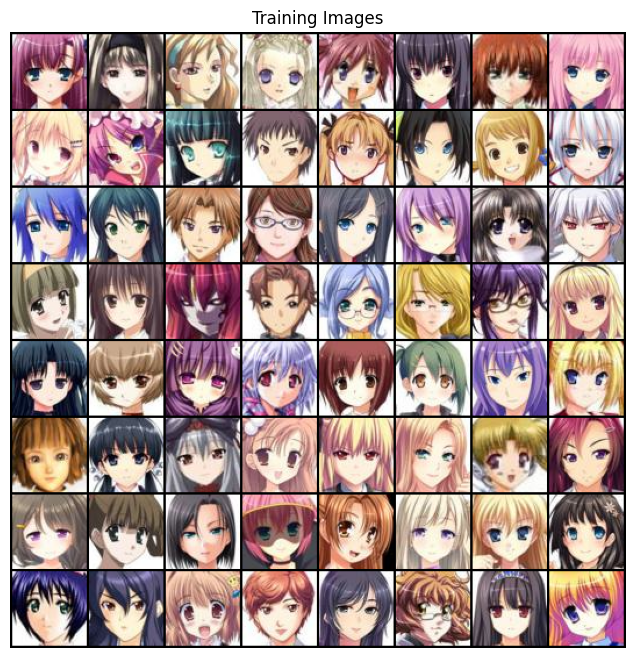

In [16]:
batch = next(iter(training_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

Note that the dataset is quite imbalanced regarding the gender distribution of the characters displayed in it. A large majority of the characters are female, while rather few of them are male.

However, because of time constraints and our belief that gender should no longer be a boundary, we decide to ignore this fact and proceed with the training without labeling/splitting the data.

## Buiding a generative model using ```torch```

### Variational Auto-Encoder (VAE)



[Variational Auto-Encoders](https://arxiv.org/abs/1312.6114) (VAEs) were introduced in 2014 by Kingma and Welling. They learn to sample from the target distribution by encoding input data into a lower-dimensional latent space and decoding the latent representation back into the original data.

During training, a VAE learns to map the input data to a given distribution in the latent space, and to reconstruct the original image from the latent representation. Inference is simply done by sampling from the latent distribution and decoding this input.

The key idea behind VAEs is to regularize the latent space to encourage it to follow a specific distribution, typically a multivariate Gaussian distribution. This is achieved by adding a regularization term to the loss function that penalizes the deviation of the learned distribution from the target distribution. The regularization term is defined using the Kullback-Leibler (KL) divergence between the learned distribution and the target distribution.

You can find a formal explanation of auto-encoders, VAE (and Beta-VAE) [here](https://lilianweng.github.io/posts/2018-08-12-vae/#vae-variational-autoencoder).

In [17]:
def vae_loss(x, x_hat, mu, log_var, beta):
    recon_loss = F.mse_loss(x, x_hat)
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = recon_loss + beta * kld_loss
    return loss

Let us define the model. It consists of two modules - the encoder and the decoder.

In [18]:
class VAE(nn.Module):


    def __init__(self, nb_channels, n_features, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        hidden_dims = [32, 64, 128, 256, 512]
        in_channels = nb_channels
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= nb_channels,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return  x_hat, mu, log_var

We need to set the model's hyperparameters (model size), as well as the training hyperparameters.

In [19]:
# Model hyperparameters
latent_dim = 256
features = 64

# Instantiate the model
vae = VAE(channels, features, latent_dim)
print(vae)

# Training hyperparameters
epochs = 20
learning_rate = 1e-4
betas = (0.9, 0.999)
KL_weight = 1e-4
optimizer = optim.Adam(vae.parameters(), lr=learning_rate, betas=betas)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequentia

To avoid being stuck in the training phase for months, we need to use GPUs.

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

vae.to(device)

print(device)

cuda


In [21]:
steps = 0
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch} of {epochs}.")
    total_loss = 0
    for x in tqdm(training_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, log_var = vae(x)
        loss = vae_loss(x, x_hat, mu, log_var, KL_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        steps += 1
    print(f"Mean loss over the last epoch: {total_loss / len(training_loader.dataset):.4f}")
    print()

Epoch 1 of 20.


100%|██████████| 249/249 [00:28<00:00,  8.74it/s]


Mean loss over the last epoch: 0.0023

Epoch 2 of 20.


100%|██████████| 249/249 [00:25<00:00,  9.80it/s]


Mean loss over the last epoch: 0.0017

Epoch 3 of 20.


100%|██████████| 249/249 [00:25<00:00,  9.67it/s]


Mean loss over the last epoch: 0.0017

Epoch 4 of 20.


100%|██████████| 249/249 [00:25<00:00,  9.61it/s]


Mean loss over the last epoch: 0.0017

Epoch 5 of 20.


100%|██████████| 249/249 [00:25<00:00,  9.61it/s]


Mean loss over the last epoch: 0.0016

Epoch 6 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.55it/s]


Mean loss over the last epoch: 0.0016

Epoch 7 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.53it/s]


Mean loss over the last epoch: 0.0016

Epoch 8 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.50it/s]


Mean loss over the last epoch: 0.0016

Epoch 9 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.45it/s]


Mean loss over the last epoch: 0.0015

Epoch 10 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.48it/s]


Mean loss over the last epoch: 0.0015

Epoch 11 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.36it/s]


Mean loss over the last epoch: 0.0015

Epoch 12 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.50it/s]


Mean loss over the last epoch: 0.0015

Epoch 13 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.52it/s]


Mean loss over the last epoch: 0.0015

Epoch 14 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.48it/s]


Mean loss over the last epoch: 0.0015

Epoch 15 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.29it/s]


Mean loss over the last epoch: 0.0015

Epoch 16 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.35it/s]


Mean loss over the last epoch: 0.0015

Epoch 17 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.34it/s]


Mean loss over the last epoch: 0.0015

Epoch 18 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.37it/s]


Mean loss over the last epoch: 0.0015

Epoch 19 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.41it/s]


Mean loss over the last epoch: 0.0015

Epoch 20 of 20.


100%|██████████| 249/249 [00:26<00:00,  9.42it/s]

Mean loss over the last epoch: 0.0015



Once the training is completed, we can run the inference and display the generated images.

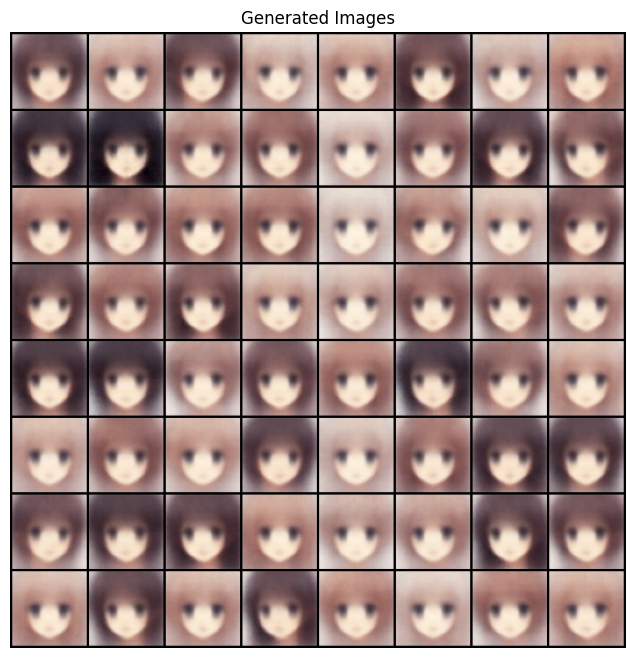

In [22]:
batch_size = 64

with torch.no_grad():
    random_noise = torch.randn(batch_size, latent_dim, device=device)
    batch = vae.decode(random_noise)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(), (1, 2, 0)))

To save the model's weights, use the following command:

In [ ]:
try:
    os.mkdir(f"./example_models/")
except FileExistsError:
    pass

torch.save(vae.state_dict(), f"./example_models/vae_{steps}.pth")

To load it back, use ```load_state_dict()```:

In [ ]:
del(vae)

vae = VAE(channels, features, latent_dim).to(device)
vae.load_state_dict(torch.load(f"./example_models/vae_{steps}.pth"))

### Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) were introduced in 2014 by [Goodfellow et al.](https://arxiv.org/abs/1406.2661), and have been extensively improved and used for diverse generative modeling tasks since then. GANs are a type of generative model that involves training two networks: a generator and a discriminator. The generator is trained to produce realistic samples from the target distribution and the discriminator to correctly distinguish between real and generated samples.

During training, the generator takes random noise as input and generates a sample, which is then fed into the discriminator along with real samples from the training data. The discriminator network learns to correctly classify the samples as real or fake, while the generator network learns to generate samples that fool the discriminator into thinking they are real. This process can be thought of as a game between the generator and discriminator. The game is considered to be a zero-sum game, as the loss of one network is equal to the gain of the other network.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, channels, latent, features):
        super(Generator, self).__init__()
        self.body = nn.Sequential(
            nn.ConvTranspose2d(latent, features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 8, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 4, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 2, features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(True),

            nn.ConvTranspose2d(features, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.body(x)


class Discriminator(nn.Module):
    def __init__(self, channels, features):
        super(Discriminator, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.body(x)

Once again, we need to choose the dimensions of our model and the training parameters. This time we have two optimizers, since we need to train two neural networks.

In [ ]:
# Models dimensions
latent_size = 100
features_g = 64
features_d = 64

# Instantiate the models and initialize the weights
generator = Generator(channels, latent_size, features_g).to(device)
generator.apply(weights_init)
print(generator)

discriminator = Discriminator(channels, features_d).to(device)
discriminator.apply(weights_init)
print(discriminator)

# Training hyper-parameters
epochs = 25
lr_g = 2e-4
lr_d = 2e-4
beta1 = 0.5

optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999))

Generator(
  (body): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


We also need to set a convention for the discriminator to distinguish between real and fake samples.

In [ ]:
criterion = nn.BCELoss()

# convention
real_label = 1.
fake_label = 0.

We can now start training.

In [ ]:
g_losses = []
d_losses = []
results = {
    "d_real_score": [],
    "d_fake_score": [],
    "d_fake_score_2": [],
    "loss_d": [0.],
    "loss_g": [0.],
}
steps = 0

In [ ]:
generator.train()
discriminator.train()

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch} of {epochs}.")
    print(f'Last epoch mean discriminator loss: {results["loss_d"][-1]}.')
    print(f'Last epoch mean generator loss: {results["loss_g"][-1]}.')
    running = {
        "d_real_score": 0.,
        "d_fake_score": 0.,
        "d_fake_score_2": 0.,
        "loss_d": 0.,
        "loss_g": 0.,
    }
    for batch in tqdm(training_loader):
        # (1) update the discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # all-real batch
        discriminator.zero_grad()
        real_img = batch.to(device)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        real_out = discriminator(real_img).view(-1)
        loss_real = criterion(real_out, label)
        loss_real.backward()

        # all-fake batch
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        fake_out = discriminator(fake.detach()).view(-1)
        loss_fake = criterion(fake_out, label)
        loss_fake.backward()

        optimizer_d.step()

        d_real_score = real_out.mean().item()
        d_fake_score = fake_out.mean().item()
        loss_d = loss_real + loss_fake

        # (2) update the generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        fake_out = discriminator(fake).view(-1)
        loss_g = criterion(fake_out, label)
        loss_g.backward()
        optimizer_g.step()

        d_fake_score_2 = fake_out.mean().item()
        steps += 1

        running["d_real_score"] += d_real_score
        running["d_fake_score"] += d_fake_score
        running["loss_d"] += loss_d.item()
        running["d_fake_score_2"] += d_fake_score_2
        running["loss_g"] += loss_g.item()

        # for plots
        g_losses.append(loss_d.item())
        d_losses.append(loss_g.item())

    results["d_real_score"].append(running["d_real_score"] / len(training_loader))
    results["d_fake_score"].append(running["d_fake_score"] / len(training_loader))
    results["loss_d"].append(running["loss_d"] / len(training_loader))
    results["d_fake_score_2"].append(running["d_fake_score_2"] / len(training_loader))
    results["loss_g"].append(running["loss_g"] / len(training_loader))

    # Make checkpoints
    if epoch % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_{steps}.pth")
        torch.save(discriminator.state_dict(), f"./models/discriminator_{steps}.pth")

Epoch 1 of 25.
Last epoch mean discriminator loss: 0.6319004438189139.
Last epoch mean generator loss: 6.178718579342088.


100%|██████████| 249/249 [00:39<00:00,  6.35it/s]


Epoch 2 of 25.
Last epoch mean discriminator loss: 0.47660775201387673.
Last epoch mean generator loss: 5.769422788696596.


100%|██████████| 249/249 [00:41<00:00,  6.00it/s]


Epoch 3 of 25.
Last epoch mean discriminator loss: 0.48640374767493055.
Last epoch mean generator loss: 6.014204496360687.


100%|██████████| 249/249 [00:48<00:00,  5.13it/s]


Epoch 4 of 25.
Last epoch mean discriminator loss: 0.4931520419606722.
Last epoch mean generator loss: 5.756171035958102.


100%|██████████| 249/249 [01:03<00:00,  3.89it/s]


Epoch 5 of 25.
Last epoch mean discriminator loss: 0.49315841893953494.
Last epoch mean generator loss: 5.780048119734569.


100%|██████████| 249/249 [01:08<00:00,  3.61it/s]


Epoch 6 of 25.
Last epoch mean discriminator loss: 0.45263591806692294.
Last epoch mean generator loss: 5.530147980494672.


100%|██████████| 249/249 [01:08<00:00,  3.62it/s]


Epoch 7 of 25.
Last epoch mean discriminator loss: 0.42045904453619415.
Last epoch mean generator loss: 5.50322844704471.


100%|██████████| 249/249 [01:08<00:00,  3.62it/s]


Epoch 8 of 25.
Last epoch mean discriminator loss: 0.4786807575738095.
Last epoch mean generator loss: 5.656100196531978.


100%|██████████| 249/249 [01:34<00:00,  2.64it/s]


Epoch 9 of 25.
Last epoch mean discriminator loss: 0.4445729996545248.
Last epoch mean generator loss: 5.48298352884959.


100%|██████████| 249/249 [01:14<00:00,  3.36it/s]


Epoch 10 of 25.
Last epoch mean discriminator loss: 0.4894399238398755.
Last epoch mean generator loss: 5.4395467670088316.


100%|██████████| 249/249 [01:54<00:00,  2.17it/s]


Epoch 11 of 25.
Last epoch mean discriminator loss: 0.4552815151382163.
Last epoch mean generator loss: 5.263647141466179.


100%|██████████| 249/249 [01:43<00:00,  2.40it/s]


Epoch 12 of 25.
Last epoch mean discriminator loss: 0.4822034387134883.
Last epoch mean generator loss: 5.213092288219307.


100%|██████████| 249/249 [01:50<00:00,  2.25it/s]


Epoch 13 of 25.
Last epoch mean discriminator loss: 0.4614465710927684.
Last epoch mean generator loss: 5.0496827296942595.


100%|██████████| 249/249 [01:54<00:00,  2.17it/s]


Epoch 14 of 25.
Last epoch mean discriminator loss: 0.47993695857115537.
Last epoch mean generator loss: 5.009860177356076.


100%|██████████| 249/249 [01:49<00:00,  2.27it/s]


Epoch 15 of 25.
Last epoch mean discriminator loss: 0.42627806262857465.
Last epoch mean generator loss: 5.23918636209036.


100%|██████████| 249/249 [01:14<00:00,  3.36it/s]


Epoch 16 of 25.
Last epoch mean discriminator loss: 0.4642742200937855.
Last epoch mean generator loss: 5.067384958506588.


100%|██████████| 249/249 [01:39<00:00,  2.50it/s]


Epoch 17 of 25.
Last epoch mean discriminator loss: 0.45171588095256604.
Last epoch mean generator loss: 5.0359564323023145.


100%|██████████| 249/249 [01:39<00:00,  2.50it/s]


Epoch 18 of 25.
Last epoch mean discriminator loss: 0.3971422527389354.
Last epoch mean generator loss: 4.880439858120608.


100%|██████████| 249/249 [01:14<00:00,  3.36it/s]


Epoch 19 of 25.
Last epoch mean discriminator loss: 0.44987921689049787.
Last epoch mean generator loss: 5.0358305638094985.


100%|██████████| 249/249 [01:44<00:00,  2.38it/s]


Epoch 20 of 25.
Last epoch mean discriminator loss: 0.44358327693070276.
Last epoch mean generator loss: 4.785363001995776.


100%|██████████| 249/249 [01:30<00:00,  2.76it/s]


Epoch 21 of 25.
Last epoch mean discriminator loss: 0.6158350352571911.
Last epoch mean generator loss: 4.738386856025481.


100%|██████████| 249/249 [01:23<00:00,  3.00it/s]


Epoch 22 of 25.
Last epoch mean discriminator loss: 0.39834463433269035.
Last epoch mean generator loss: 4.6344717403492295.


100%|██████████| 249/249 [01:39<00:00,  2.51it/s]


Epoch 23 of 25.
Last epoch mean discriminator loss: 0.47110030414110204.
Last epoch mean generator loss: 4.777719742293099.


100%|██████████| 249/249 [01:37<00:00,  2.56it/s]


Epoch 24 of 25.
Last epoch mean discriminator loss: 0.4702364161281461.
Last epoch mean generator loss: 4.694686647758905.


100%|██████████| 249/249 [01:21<00:00,  3.06it/s]


Epoch 25 of 25.
Last epoch mean discriminator loss: 0.3443079823889886.
Last epoch mean generator loss: 5.0323727545010515.


100%|██████████| 249/249 [01:44<00:00,  2.38it/s]


Plot the training results to make sure everything went smoothly.

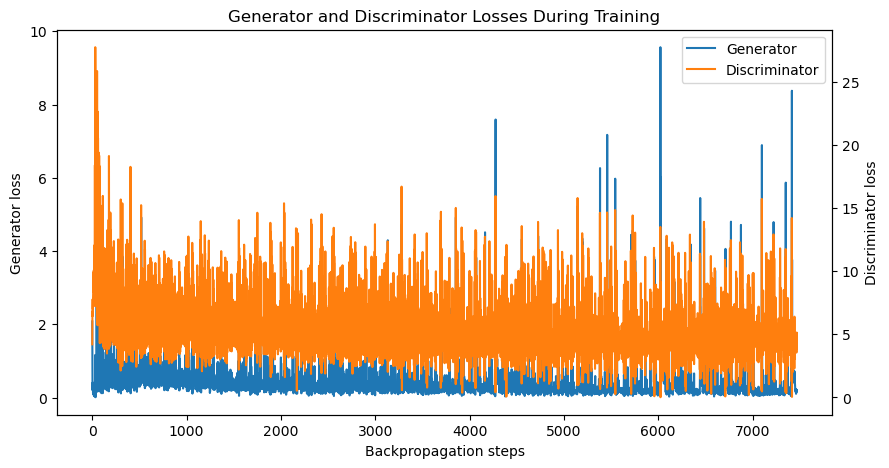

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses During Training")
ax1 = plt.subplot()
l1, = ax1.plot(g_losses, color="tab:blue")
ax2 = ax1.twinx()
l2, = ax2.plot(d_losses, color="tab:orange")
ax1.set_xlabel("Backpropagation steps")
ax1.set_ylabel("Generator loss")
ax2.set_ylabel("Discriminator loss")
plt.legend([l1, l2], ["Generator", "Discriminator"])
plt.show()

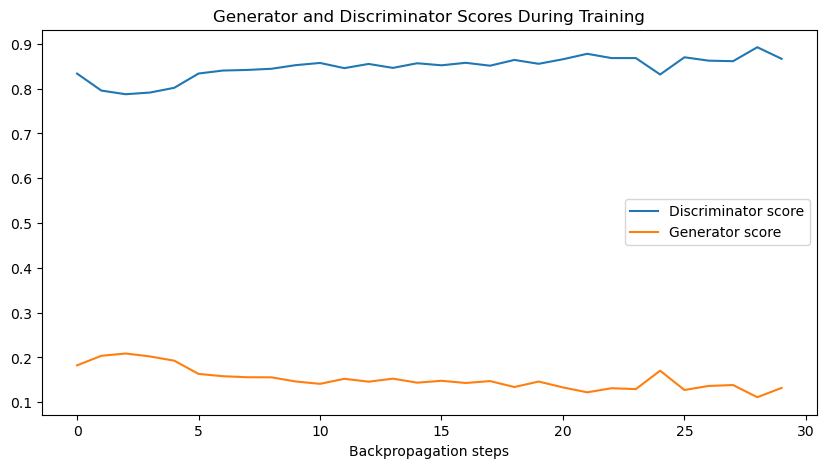

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Scores During Training")
plt.plot(results["d_real_score"], label="Discriminator score", color="tab:blue")
plt.plot(results["d_fake_score"], label="Generator score", color="tab:orange")
plt.xlabel("Backpropagation steps")
plt.legend()
plt.show()

The generator never caught up to the generator. In an ideal setting, both scores converge to $0.5$ - this is the characterization of the Nash equilibrium proven by [Goodfellow et al.](https://arxiv.org/abs/1406.2661). By adjusting the learning rates and maybe changing the training strategy (e.g. two steps for the generator - one step for the discriminator), one could hope to achieve better convergence. Keep in mind that GANs are known for being quite unstable and it can be a pain to make them converge. [Here are some tricks}(https://github.com/soumith/ganhacks) that you can use to make your life easier when training GANs.

Inference is simply done by feeding a random Gaussian noise into the generator. The discriminator is just an auxiliary to help the generator learn the target distribution. Even though convergence was not achieved during training, we can already see some similarities between the generator outputs and the training images.

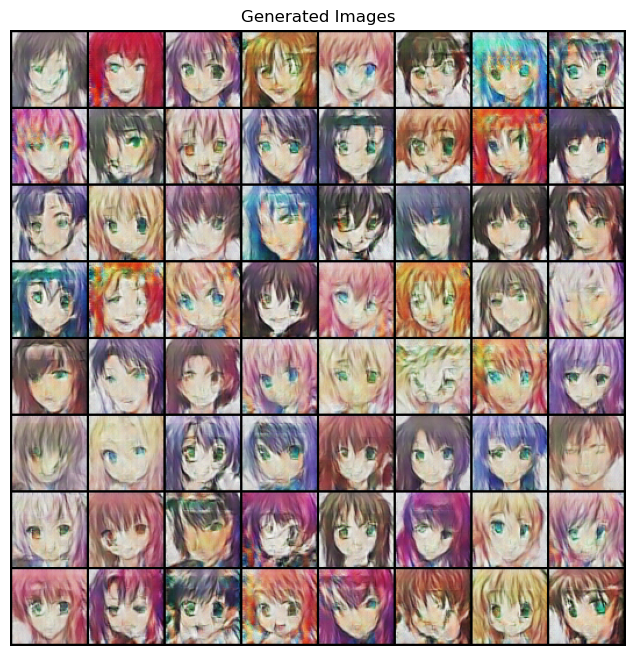

In [ ]:
generator.eval()

with torch.no_grad():
    random_noise = torch.randn(64, latent_size, 1, 1, device=device)
    batch = generator(random_noise)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(), (1, 2, 0)))

The models can be saved using the following commands:

In [ ]:
torch.save(generator.state_dict(), f"./models/generator_{steps}.pth")
torch.save(discriminator.state_dict(), f"./models/discriminator_{steps}.pth")

## Worfklow

### The model to submit

The submission consists of one ```generator.py``` file in which you will implement a ```Generator``` class. You must define a ```fit``` method which will be used to fine-tune your model on each of the three private datasets, and a ```generate``` method which samples from the learnt distribution. **Please note that ```generate``` must take a noise of size $1024$ as its only input**. You do not have to use the entirety of the noise vector to run inference on your model, but you shall not generate any random noise apart from that input.

To better understand the functioning of the ```Generator``` class, we encourage you to take a look at the ```starting_kit``` submission. If you want to build a VAE or a GAN, you can take inspiration from the example submissions.

### Evaluation

Evaluating a generative model is not simple because it is not exactly a supervised problem. There is no objective loss function that can assess how good the generative model is on its own.

We could think that we'd simply have to generate data with our generative model, then assess how good it is. However, we cannot simply qualitatively evaluate the model just by viewing the generated data, because such a review is highly subjective and accounts for our own biases. Moreover, deciding what is a good generated sample requires domain knowledge that cannot be easily acquired in practice. Moreover, it becomes a problem if we have to review a very large amount of generated images.

Instead, there exist metrics that can quantitatively evaluate generative models based on the quality and the diversity of the generated images.

In general, in order to evaluate a generative model, two main properties have to be assessed:

- **Fidelity**: The quality of the generated samples. Do they resemble the true samples from the original dataset?
- **Diversity**: The variety of the generated samples. Do we generate enough different samples? Does the distribution of generated samples resemble the distribution of original samples?

For that purpose, three metrics are computed.

| Metric         | Fréchet Inception Score | Kernel Inception Score | Inception Score |
|--------------|-----------|------------------------|-----------------|
| The higher the better | False      | False       | True
| Uses the pre-trained Inception v3      | True  | True       | True
| Uses the real data | True | True | False |
| Requires a very large sample size | True | False | False |


To verify that the noise given as input to the generate method is taken into account for the generation of the data, a fourth metric `L1_norm_interpolation` is calculated. This metric gives similar noises to the generator and compares the generated images with the L1 norm. The `L1_norm_interpolation` metric is the largest L1 norm found by making the difference between two images with similar generation noise.
Thus the closer `L1_norm_interpolation` is to 0, the better.

A last metric, the `mixed` score, combines the four previous metrics and is used to rank the generators. The higher the mixed score, the better the generator.

In [ ]:
fid = FrechetInceptionDistance(reset_real_features=True, normalize=True).to(device)
kid = KernelInceptionDistance(reset_real_features=True, normalize=True).to(device)
is_ = InceptionScore(normalize=True).to(device)
train_batch = next(iter(training_loader)).to(device)

# Real data
for batch in tqdm(training_loader):
    fid.update(train_batch, real=True)
    kid.update(train_batch, real=True)
# Fake data
with torch.no_grad():
    for _ in range(100):
        random_noise = torch.randn(64, latent_size, 1, 1, device=device)
        batch = generator(random_noise)
        fid.update(batch, real=False)
        kid.update(batch, real=False)
        is_.update(batch)

fid_score = fid.compute().item()
kid_score = kid.compute()
is_score = is_.compute()

print("FID : ", fid_score)
print("KID : ", f"{kid_score[0].item()} +- {kid_score[1].item}")
print("IS : ", f"{is_score[0].item()} +- {is_score[1].item}")

C:\Users\bilid\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
C:\Users\bilid\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 249/249 [04:52<00:00,  1.18s/it]


In order to shorten the training process, one can try to save the weights of a model they have trained beforehand, and load it in the training process when using the functionalities of `ramp-test`. Keep in mind that these metrics are computationally expensive and take time to compute, hence make sure that your model is ready before running an evaluation.

### Cross-validation

In a generative challenge, there is no cross-validation either. However, this challenge evaluates the ability of the participant's model to adapt to more precise distributions of data.

In more realistic terms, the model needs to be able to learn from different sets of faces and adapt its generated samples to match each of those different sets. For instance, let's say that anime characters with blue hair become a popular topic and form an audience which tastes we need to cater to. In that case, the model needs to be able to adapt to a dataset that mostly contains blue-haired characters.

This is why we cannot simply limit ourselves to loading the weights of a model we trained beforehand. Although it can shorten the training process and avoid training from scratch, fine-tuning needs to be done, hence we cannot entirely skip the training process.

In `ramp-test`, the model is evaluated on all the above metrics, but only trained and evaluated on each of the three training sets separately in each fold. The bagged scores, however, account for all the true data in every set and the predictions in each of the validation folds.

### Submitting to the online challenge

Once you found a good model, you can submit them to ramp.studio to enter the online challenge. First, if it is your first time using the RAMP platform, sign up, otherwise log in. Then sign up to the event solar_wind. Sign up for the event. Both signups are controled by RAMP administrators, so there can be a delay between asking for signup and being able to submit.

Once your signup request is accepted, you can go to your sandbox and copy-paste. You can also create a new starting-kit in the submissions folder containing estimator.py and upload this file directly. You can check the starting kits for examples of GANs and VAEs. The submission is trained and tested on our backend in the similar way as ramp-test does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in my submissions. Once it is trained, you get a mail, and your submission shows up on the public leaderboard. If there is an error (despite having tested your submission locally with ramp-test), it will show up in the "Failed submissions" table in my submissions. You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is private and usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., locally, and checking them with ramp-test. The script prints mean cross-validation scores.

In [ ]:
# --quick-test to select only a small part of the data
!ramp-test --submission dcgan


Usage: ramp-test [OPTIONS]
Try 'ramp-test -h' for help.

Error: Got unexpected extra arguments (# to select only a small part of the data)
